# Dataloader

In [1]:
from torch.utils.data import Dataset
import torch
import numpy as np
import os

class Dataset_TPE(Dataset):
    def __init__(self, configs, mode):
        self.datapath = configs.datapath
        self.data_type = configs.data_type
        self.max_value = configs.max_value
        if mode == 'train':
            self.name = 'train_' + self.data_type + '.npz'
        elif mode == 'valid':
            self.name = 'valid_' + self.data_type + '.npz'
        else:
            self.name = 'test_' + self.data_type + '.npz'
        path = os.path.join(self.datapath, self.name)
        self.data = self.load_data(path)

    def load_data(self, path):
        all_data = np.load(path)
        self.XC = all_data['xc']
        self.XP = all_data['xp']
        self.XT = all_data['xt']
        self.YS = all_data['ys']
        self.YD = all_data['yd']

        print(self.XC.shape, self.XP.shape, self.XT.shape, self.YS.shape, self.YD.shape, self.max_value)

        return all_data

    def __len__(self):
        return self.data['xc'].shape[0]

    def __getitem__(self, item):
        XC = torch.FloatTensor(self.XC[item])
        XP = torch.FloatTensor(self.XP[item])
        XT = torch.FloatTensor(self.XT[item])
        YS = torch.FloatTensor(self.YS[item])
        YD = torch.FloatTensor(self.YD[item])

        return XC, XP, XT, YS, YD


# Modules

In [2]:
import torch
import torch.nn as nn


class CGL(nn.Module):
    def __init__(self, in_channel, num_hidden, filter_size, stride, is_norm):
        super(CGL, self).__init__()

        self.num_hidden = num_hidden
        self.padding = filter_size // 2
        self.forget_bias = -1.0

        if is_norm:
            self.conv_x = nn.Sequential(
                nn.Conv2d(in_channel, num_hidden * 4, kernel_size=filter_size, stride=stride, padding=self.padding),
                nn.GroupNorm(num_hidden // 2, 4 * num_hidden)
            )
            self.conv_c = nn.Sequential(
                nn.Conv2d(num_hidden, num_hidden * 2, kernel_size=filter_size, stride=stride, padding=self.padding),
                nn.GroupNorm(num_hidden // 2, num_hidden * 2)
            )

            self.conv_m = nn.Sequential(
                nn.Conv2d(num_hidden, num_hidden * 2, kernel_size=filter_size, stride=stride, padding=self.padding),
                nn.GroupNorm(num_hidden // 2, num_hidden * 2)
            )
            self.conv_o_c = nn.Sequential(
                nn.Conv2d(num_hidden * 2, num_hidden, kernel_size=1, stride=1, padding=0),
                nn.GroupNorm(num_hidden // 2, num_hidden)
            )
        else:
            self.conv_x = nn.Sequential(
                nn.Conv2d(in_channel, num_hidden * 4, kernel_size=filter_size, stride=stride, padding=self.padding),
            )
            self.conv_c = nn.Sequential(
                nn.Conv2d(num_hidden, num_hidden * 2, kernel_size=filter_size, stride=stride, padding=self.padding),
            )
            self.conv_m = nn.Sequential(
                nn.Conv2d(num_hidden, num_hidden * 2, kernel_size=filter_size, stride=stride, padding=self.padding),
            )
            self.conv_o_c = nn.Sequential(
                nn.Conv2d(num_hidden * 2, num_hidden, kernel_size=filter_size, stride=stride, padding=self.padding),
            )

        self.conv_last = nn.Conv2d(num_hidden * 2, num_hidden, kernel_size=1, stride=1, padding=0)

    def forward(self, x_t, c_t, m_t):
        x_concat = self.conv_x(x_t)
        m_concat = self.conv_m(m_t)
        c_concat = self.conv_c(c_t)

        x_p, f_x, x_m_p, f_m_x = torch.split(x_concat, self.num_hidden, dim=1)
        f_m, g_m = torch.split(m_concat, self.num_hidden, dim=1)
        f_c, g_c = torch.split(c_concat, self.num_hidden, dim=1)

        f_t = torch.sigmoid(f_x + f_c + self.forget_bias)
        x_p_t = torch.tanh(x_p + g_c)

        c = f_t * c_t + (1 - f_t) * x_p_t

        f_t_prime = torch.sigmoid(f_m_x + f_m + self.forget_bias)
        g_t_prime = torch.tanh(x_m_p + g_m)

        m = f_t_prime * m_t + (1 - f_t_prime) * g_t_prime

        mem = torch.cat((c, m), 1)

        o_t = torch.sigmoid(self.conv_o_c(mem))
        h_new = o_t * torch.tanh(self.conv_last(mem))

        return h_new, c, m


class self_attention(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_szie=1):
        super(self_attention, self).__init__()
        self.layer_q = nn.Conv2d(input_dim, hidden_dim, kernel_szie)
        self.layer_k = nn.Conv2d(input_dim, hidden_dim, kernel_szie)
        self.layer_v = nn.Conv2d(input_dim, hidden_dim, kernel_szie)
        self.layer_f = nn.Conv2d(hidden_dim, input_dim, kernel_szie)
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

    def forward(self, q, k, v, extra=None):
        batch_size, channel, H, W = q.shape
        h = q  # short connection

        q = self.layer_q(q)
        k = self.layer_k(k)
        v = self.layer_v(v)

        if extra is not None:
            # 外部特徵 encode 成 attention bias
            # extra shape: (B, M, H, W)
            extra_flat = extra.view(batch_size, -1, H * W)
            q = q + extra_flat.mean(dim=1, keepdim=True).unsqueeze(-1)  # broadcast to q shape
            k = k + extra_flat.mean(dim=1, keepdim=True).unsqueeze(-1)

        q = q.view(batch_size, self.hidden_dim, H * W)
        k = k.view(batch_size, self.hidden_dim, H * W)
        v = v.view(batch_size, self.hidden_dim, H * W)

        attn = torch.matmul(q.transpose(1, 2), k)
        # print('e shape is', e.shape)
        attention = torch.softmax(attn, dim=-1)  # attention
        z = torch.matmul(attention, v.permute(0, 2, 1))
        z = z.view(batch_size, self.hidden_dim, H, W)
        out = self.layer_f(z) + h

        return out, attention


# DeepMeshCity

In [3]:
from einops import rearrange


class DeepMeshCity(nn.Module):
    def __init__(self, configs):
        super(DeepMeshCity, self).__init__()
        # hyperparrams
        self.meta_in = configs.meta_dim
        self.map_width = configs.map_width
        self.patch_size = configs.patch_size
        self.resize_ratio = self.map_width // self.patch_size
        self.frame_channel = configs.map_channel
        self.clossness_len = configs.clossness_len
        self.periodic_len = configs.periodic_len
        self.trend_len = configs.trend_len
        self.device = configs.device

        # Parameter for External Meta data
        self.meta_out = self.map_width * self.map_width * self.frame_channel
        self.is_metadate = configs.is_metadate
        self.Meta_frame_channel = self.frame_channel * 2 if self.is_metadate else self.frame_channel
        self.is_extra = configs.is_extra 

        # Parameter for Model
        self.num_layers = configs.num_layers
        self.num_hidden = configs.num_hidden
        self.filter_size = configs.filter_size
        self.stride = configs.stride
        self.layer_norm = configs.layer_norm

        # Early Fusion
        if self.is_metadate:
            self.meta_learn = nn.Sequential(nn.Linear(self.meta_in, 10),
                                            nn.ReLU(),
                                            nn.Linear(10, self.meta_out),
                                            nn.ReLU())
        # if self.is_extra:
        #     self.extra = # todo
        
        # Stacked SA-CGL Blocks
        SACGL_blocks = []
        for i in range(self.num_layers):
            in_channel = self.Meta_frame_channel if i == 0 else self.num_hidden[i - 1]
            attn_channel = in_channel * self.resize_ratio * self.resize_ratio
            SACGL_blocks.append(nn.ModuleList([
                self_attention(attn_channel, self.num_hidden[i]),
                CGL(in_channel, self.num_hidden[i], self.filter_size, self.stride, self.layer_norm)
            ]))

        self.SACGL_blocks = nn.ModuleList(SACGL_blocks)

        # Output Module
        self.Output_module = nn.Sequential(
            nn.Conv2d(self.num_hidden[self.num_layers - 1], self.num_hidden[-1],
                      kernel_size=1, stride=1, padding=0, bias=False),
            nn.LeakyReLU(),
            nn.Conv2d(self.num_hidden[-1], self.frame_channel,
                      kernel_size=1, stride=1, padding=0, bias=False)
        )
    def Attention_module(self, net, i, extra=None):
        net = rearrange(net, 'b c (p1 h) (p2 w) -> b (h w c) p1 p2', p1=self.patch_size, p2=self.patch_size)
        if extra is not None:
            extra = rearrange(extra, 'b c (p1 h) (p2 w) -> b (h w c) p1 p2', p1=self.patch_size, p2=self.patch_size)
        
        net, _ = self.SACGL_blocks[i][0](net, net, net, extra)
        net = rearrange(net, 'b (h w c) p1 p2 -> b c (p1 h) (p2 w)', h=self.resize_ratio, w=self.resize_ratio)

        return net

    def forward(self, xc, xp, xt, yd):
        B, _, C, H, W = xc.shape

        if self.is_metadate:
            if yd.dim() > 2:
                yd = yd.view(yd.shape[0], -1)
            
            yd = rearrange(self.meta_learn(yd), 'b (f c h w) -> b f c h w', c=self.frame_channel,
                           h=self.map_width, w=self.map_width)

            xcd = yd.repeat(1, self.clossness_len, 1, 1, 1) if self.clossness_len > 1 else yd
            xpd = yd.repeat(1, self.periodic_len, 1, 1, 1) if self.periodic_len > 1 else yd
            xtd = yd.repeat(1, self.trend_len, 1, 1, 1) if self.trend_len > 1 else yd

            xp = torch.cat((xp, xpd), dim=2)
            xt = torch.cat((xt, xtd), dim=2)
            xc = torch.cat((xc, xcd), dim=2)

        frames = torch.cat((xt, xp, xc), dim=1)

        batch = frames.shape[0]
        height = frames.shape[-2]
        width = frames.shape[-1]

        h_t = []
        c_t = []

        for i in range(self.num_layers):
            zeros = torch.zeros([batch, self.num_hidden[i], height, width]).to(self.device)
            h_t.append(zeros)
            c_t.append(zeros)

        memory = torch.zeros([batch, self.num_hidden[0], height, width]).to(self.device)

        total_length = self.clossness_len + self.periodic_len + self.trend_len
        for t in range(total_length):
            net = frames[:, t]

            net = self.Attention_module(net, 0, extra=self.is_extra)
            
            h_t[0], c_t[0], memory = self.SACGL_blocks[0][1](net, c_t[0], memory)

            for i in range(1, self.num_layers):
                h_t[i - 1] = self.Attention_module(h_t[i - 1], i, extra=self.is_extra)
                h_t[i], c_t[i], memory = self.SACGL_blocks[i][1](h_t[i - 1], c_t[i], memory)

        x_gen = self.Output_module(h_t[self.num_layers - 1])
        return x_gen


# model_factory

In [4]:
def build_model(configs):
    networks_map = {
        'DeepMeshCity_TPE': DeepMeshCity,
    }
    model_type = configs.model_type

    if model_type in networks_map:
        Network = networks_map[model_type]
        network = Network(configs).to(configs.device)
        return network
    else:
        raise ValueError('Name of network unknown %s' % model_type)

# grid in csv to array

In [5]:
import pandas as pd

# 假設你的檔案叫 tpe_grids.csv
df = pd.read_csv("dataset_4yr\TPE_113_grid.csv")

# 取出所有 grid 欄位 (去掉 'index')
grid_columns = [col for col in df.columns if col.startswith("grid_")]
print(grid_columns)


['grid_271', 'grid_300', 'grid_301', 'grid_188', 'grid_302', 'grid_189', 'grid_303', 'grid_299', 'grid_216', 'grid_217', 'grid_331', 'grid_218', 'grid_215', 'grid_244', 'grid_245', 'grid_246', 'grid_272', 'grid_247', 'grid_273', 'grid_274', 'grid_275', 'grid_243', 'grid_420', 'grid_416', 'grid_417', 'grid_418', 'grid_419', 'grid_447', 'grid_308', 'grid_304', 'grid_305', 'grid_306', 'grid_307', 'grid_392', 'grid_388', 'grid_389', 'grid_390', 'grid_391', 'grid_386', 'grid_387', 'grid_414', 'grid_415', 'grid_276', 'grid_277', 'grid_278', 'grid_279', 'grid_364', 'grid_360', 'grid_361', 'grid_362', 'grid_363', 'grid_358', 'grid_359', 'grid_248', 'grid_249', 'grid_250', 'grid_332', 'grid_333', 'grid_334', 'grid_335', 'grid_330', 'grid_448', 'grid_220', 'grid_475', 'grid_221', 'grid_336', 'grid_219', 'grid_238', 'grid_239', 'grid_266', 'grid_267', 'grid_296', 'grid_184', 'grid_185', 'grid_186', 'grid_187', 'grid_294', 'grid_295', 'grid_183', 'grid_324', 'grid_212', 'grid_213', 'grid_214', 'gr

<>:4: SyntaxWarning: invalid escape sequence '\T'
<>:4: SyntaxWarning: invalid escape sequence '\T'
C:\Users\user\AppData\Local\Temp\ipykernel_35560\3244742007.py:4: SyntaxWarning: invalid escape sequence '\T'
  df = pd.read_csv("dataset_4yr\TPE_113_grid.csv")


In [6]:
def grid_id_to_index(grid_id, ncols=28):
    # 假設 grid_id 是 0 開始編號的 28*28 flatten
    row = grid_id // ncols
    col = grid_id % ncols
    return row, col


In [52]:
import numpy as np

# 建立一個 mask (28x28)
mask = np.zeros((28, 28), dtype=bool)
count = 0
for col in grid_columns:
    grid_id = int(col.replace("grid_", ""))
    grid_id = grid_id - 1  # 假設 grid_id 從 1 開始，轉換為 0 開始
    row, col = grid_id_to_index(grid_id)
    mask[col, row] = True
    count += 1

c:\Users\user\Desktop\work\DeepMeshCity\testenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21488 (\N{CJK UNIFIED IDEOGRAPH-53F0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\work\DeepMeshCity\testenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21271 (\N{CJK UNIFIED IDEOGRAPH-5317}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\work\DeepMeshCity\testenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\work\DeepMeshCity\testenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\Desktop\work\DeepMeshCity\testenv\Lib\site-packages\IPytho

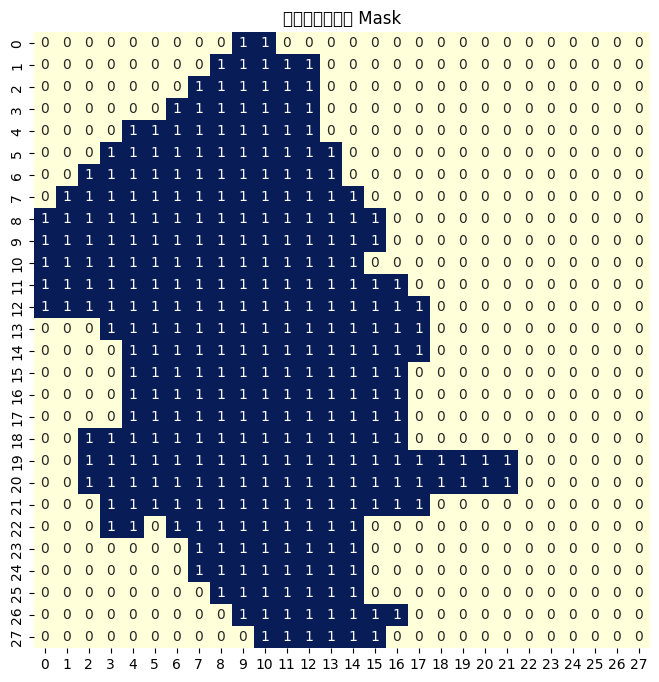

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(mask, annot=True, fmt="d", cmap="YlGnBu", cbar=False, square=True)
plt.title("台北市有效網格 Mask")
plt.show()

# evaluate

In [ ]:
import datetime
import seaborn as sns
import numpy as np
import os.path
import torch
import matplotlib
import matplotlib.pyplot as plt

matplotlib.use('Agg')


def evaluate_model(model, MSE_criterion, DataLoader, device, configs, is_save, itr=999):
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'test...')

    res_path = os.path.join(configs.gen_frm_dir, str(itr))
    if not os.path.exists(res_path):
        os.mkdir(res_path)
    avg_mse = 0
    avg_rmse = 0
    avg_mae = 0
    correct_count = 0
    item_count = 0
    batch_id = 0

    loss_list = []
    model.eval()
    all_tre = []
    # only taipei
    
    with torch.no_grad():
        for batch, item in enumerate(DataLoader):
            print("batch", batch)
            batch_id = batch_id + 1
            item_count = item_count+1
            xc, xp, xt, ys, yd = item
            xc, xp, xt, ys, yd = list(map(lambda x: x.to(device), [xc, xp, xt, ys, yd]))
            pred = model(xc, xp, xt, yd)
            # 準備 mask (B, 1, H, W)
            B, C, H, W = ys.shape
            valid_mask = torch.tensor(mask, dtype=ys.dtype, device=device).unsqueeze(0).unsqueeze(0)
            valid_mask = valid_mask.expand(B, C, H, W)
            valid_mask_np = valid_mask.cpu().numpy()
            
            print("valid_mask shape:", valid_mask.shape)
            pred = pred * valid_mask
            ys = ys * valid_mask
            print("pred shape:", pred.shape, "ys shape:", ys.shape)
            # # masked diff
            # diff = (pred - ys) * valid_mask
            # # loss
            # mse = torch.mean(diff ** 2)
            # mae = torch.mean(torch.abs(diff))
            # rmse = torch.sqrt(torch.mean(diff ** 2))
            
            loss = MSE_criterion(pred, ys)
            loss_item = loss.cpu().item()
            loss_list.append(loss_item)
            #print("validation:batch ",batch,"loss=",loss_item)
            # MSE per frame
            x = ys.cpu().numpy() * configs.max_value  # (B, H, W, C)
            gx = pred.cpu().numpy() * configs.max_value
            # gx[gx < 1] = 0
            
            mae = np.mean(np.abs(x - gx))
            mse = np.mean(np.square(x - gx))
            rmse = np.mean(np.square(x - gx))
            
            avg_mae += mae
            avg_mse += mse
            avg_rmse += rmse
            
            # TRE
            
            B = x.shape[0]  # 每個 batch 中有 B 筆資料
            for i in range(B):
                valid = valid_mask_np[i]
                correct = np.sum((np.abs(x[i] - gx[i]) < 1) * valid)
                tre = (1 - correct / count) * 100
                all_tre.append(tre)
                # draw 
                if TRE_draw == True:
                    error = x[i] - gx[i]
                    error = np.squeeze(x[i] - gx[i])
                    
                    fig = sns.heatmap(error, annot=True,annot_kws={"size": 3}, fmt=".3f", vmin=0, xticklabels=False,
                        yticklabels=False, cbar=False, cmap='rainbow', square=True)
                    heatmap = fig.get_figure()
                    heatmap.savefig(os.path.join("error_map", f"error_map_{i}.png"), dpi=300, bbox_inches='tight')
                    plt.clf()
                    # debug
                    fig = sns.heatmap(np.squeeze(x[i]), annot=True,annot_kws={"size": 3}, fmt=".3f", vmin=0, xticklabels=False,
                        yticklabels=False, cbar=False, cmap='rainbow', square=True)
                    heatmap = fig.get_figure()
                    heatmap.savefig(os.path.join("error_map", f"true_{i}.png"), dpi=300, bbox_inches='tight')
                    plt.clf()
            # save prediction examples
            if batch_id <= configs.num_save_samples:
                path = os.path.join(res_path, str(batch_id))
                if not os.path.exists(path):
                    os.mkdir(path)
                for i in range(configs.input_length):
                    name = 'gt' + str(i + 1) + '.png'
                    file_name = os.path.join(path, name)
                    img_c = xc[0, i, 0, :, :].cpu().numpy()
                    draw_pic(img_c, file_name, configs.max_value)

                name = 'pd7' + '.png'
                file_name = os.path.join(path, name)
                img_pd = pred[0, 0, :, :].cpu().numpy()
                draw_pic(img_pd, file_name, configs.max_value)

                name = 'gt7' + '.png'
                file_name = os.path.join(path, name)
                img_gt = ys[0, 0, :, :].cpu().numpy()
                draw_pic(img_gt, file_name, configs.max_value)

        avg_mse = avg_mse / batch_id
        avg_mae = avg_mae / batch_id
        avg_rmse = np.sqrt(avg_rmse / batch_id)
        
        # TRE
        # total_pixels = x.size * batch_id
        # tre = (1 - correct_count / total_pixels) * 100
        sum_tre = np.sum(all_tre)
        print("sum_tre:", sum_tre)
        print("count:", count)
        avg_tre = sum_tre / count
        print('mse per frame: {}, rmse per frame: {}, mae per frame: {}, avg_tre : {} %'.format(avg_mse, avg_rmse, avg_mae,avg_tre))
        if(is_save):
            save_dir = "report"
            os.makedirs(save_dir, exist_ok=True)
            now_str = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
            log_path = os.path.join(save_dir, now_str + ".txt")
            with open(log_path, "w") as log_file:
                log_file.write('mse per frame: {}, rmse per frame: {}, mae per frame: {}, avg_tre : {} %'.format(avg_mse, avg_rmse, avg_mae,avg_tre))
        # save tre
        with open("report/individual_tre.txt", "w") as f:
            for i, tre in enumerate(all_tre):
                f.write(f"Sample {i}: TRE = {tre:.2f}%\n")
    return avg_mse, avg_rmse, avg_mae, tre


def draw_pic(img_gt, file_name,denorm_factor=1.0 ):
    img_gt[img_gt > 0.2] = 0.2
    factor = 1.0 / 3.0
    img_gt[(img_gt > 0.05) & (img_gt <= 0.2)] = img_gt[(img_gt > 0.05) & (img_gt <= 0.2)] * factor + 2 * factor * 0.05
    img_gt = img_gt * denorm_factor
    fig = sns.heatmap(img_gt, annot=True,annot_kws={"size": 3}, fmt=".3f", vmin=0, xticklabels=False,
                      yticklabels=False, cbar=False, cmap='rainbow', square=True)
    heatmap = fig.get_figure()
    heatmap.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.clf()

# evaluate_model_with_custom_YD

In [21]:
def evaluate_model_with_custom_YD(model, DataLoader, MSE_criterion, device, target_feature_idx, configs):
    print("evaluate_model_with_custom_YD:", target_feature_idx)
    model.eval()
    total_loss = 0
    correct_count = 0
    batch_id = 0
    avg_mse = 0
    avg_rmse = 0
    avg_mae = 0
    with torch.no_grad():
        for batch, item in enumerate(DataLoader):
            batch_id = batch_id + 1
            xc, xp, xt, ys, yd = item
            XC = xc.to(device)
            XP = xp.to(device)
            XT = xt.to(device)
            YS = ys.to(device)
            YD = yd.to(device)
            print("YD shape:", YD.shape)

            YD_modified = YD.clone()
            YD_modified[:, target_feature_idx] = 0  

            pred = model(XC, XP, XT, YD_modified)
            loss = MSE_criterion(pred, YS)
            # MSE per frame
            x = ys.cpu().numpy() * configs.max_value  # (B, H, W, C)
            gx = pred.cpu().numpy() * configs.max_value
            # gx[gx < 1] = 0
            
            mae = np.mean(np.abs(x - gx))
            mse = np.mean(np.square(x - gx))
            rmse = np.mean(np.square(x - gx))
            
            avg_mae += mae
            avg_mse += mse
            avg_rmse += rmse
            # TRE
            correct_count += np.sum(np.abs(x - gx) < 1)
    avg_mse = avg_mse / batch_id
    avg_mae = avg_mae / batch_id
    avg_rmse = np.sqrt(avg_rmse / batch_id)

    # TRE
    total_pixels = x.size * batch_id
    tre = (1 - correct_count / total_pixels) * 100
    return avg_mse, avg_rmse, avg_mae, tre


# trainer_epoch

In [22]:
from torch.autograd import Variable
from tqdm import tqdm
import torch


def train_epoch(model, optimizer, loss_func, dataloader, lr_scheduler, epoch, device):
    loss_list = []
    model.train()
    print("The learning rate of the %dth epoch：%f" % (epoch, optimizer.param_groups[0]['lr']))
    for batch, item in tqdm(enumerate(dataloader)):
        xc, xp, xt, ys, yd = item
        xc, xp, xt, ys, yd = list(map(lambda x: Variable(x.to(device)), [xc, xp, xt, ys, yd]))
        optimizer.zero_grad()
        next_frame = model(xc, xp, xt, yd)
        loss = loss_func(next_frame, ys)
        
        loss.backward()
        optimizer.step()
        loss_item = loss.cpu().item()
        #print("train: batch ",batch,"loss=",loss_item)
        loss_list.append(loss_item)

    if lr_scheduler is not None:
        lr_scheduler.step(epoch)

    return sum(loss_list) / len(loss_list)


def test_epoch(model, loss_func, DataLoader, device):
    loss_list = []
    model.eval()
    with torch.no_grad():
        for batch, item in tqdm(enumerate(DataLoader)):
            xc, xp, xt, ys, yd = item
            xc, xp, xt, ys, yd = list(map(lambda x: x.to(device), [xc, xp, xt, ys, yd]))
            next_frame = model(xc, xp, xt, yd)

            loss = loss_func(next_frame, ys)
            loss_list.append(loss.detach().cpu().item())

    return sum(loss_list) / len(loss_list)


# trainer

In [55]:
import os
from torch.utils.data import DataLoader
from torch import optim
import time
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_loss_curves(train_loss_epoch, val_loss_epoch, tre_epoch, save_dir='loss_plots'):
    """
    畫出訓練/驗證 loss 曲線與 tre_epoch 變化，並分別儲存圖片。
    :param train_loss_epoch: List of training losses per epoch
    :param val_loss_epoch: List of validation losses per epoch
    :param tre_epoch: List of "tre" values per epoch
    :param save_dir: Directory to save the plots
    """
    os.makedirs(save_dir, exist_ok=True)

    # Plot training loss
    plt.figure()
    plt.plot(train_loss_epoch, label='Train Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'train_loss.png'))
    plt.close()

    # Plot validation loss
    plt.figure()
    plt.plot(val_loss_epoch, label='Validation Loss', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'val_loss.png'))
    plt.close()

    # Plot TRE (or third metric)
    plt.figure()
    plt.plot(tre_epoch, label='TRE', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('TRE')
    plt.title('TRE over Epochs')
    plt.grid(True)
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'tre.png'))
    plt.close()

def  train_main(cfg, save = False):
    # config
    train_cfg = cfg.train_cfg
    dataset_cfg = cfg.dataset_cfg
    model_cfg = cfg.model_cfg
    device = cfg.device

    # dataset
    train_dataset = Dataset_TPE(dataset_cfg, mode='train')
    val_dataset = Dataset_TPE(dataset_cfg, mode='valid')
    train_loader = DataLoader(train_dataset, batch_size=train_cfg.batch_size, shuffle=True, pin_memory=True,
                              drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=train_cfg.batch_size, shuffle=False, pin_memory=True,
                            drop_last=True)

    print(train_cfg.optimizer_cfg)
    # build model
    model = build_model(model_cfg).to(device)

    # whether Parallel
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)
    if torch.cuda.device_count() == 1:
        print("there is 1 GPU")
    parameters = model.parameters()

    # Parameter information
    print('Net\'s state_dict:')
    total_param = 0
    for param_tensor in model.state_dict():
        print(param_tensor, '\t', model.state_dict()[param_tensor].size())
        total_param += np.prod(model.state_dict()[param_tensor].size())
    print('Net\'s total params:', total_param)

    # loss
    MSE_criterion = nn.MSELoss().to(device)

    # optimizer
    optimizer_cfg = train_cfg.optimizer_cfg
    lr_scheduler_cfg = train_cfg.lr_scheduler_cfg
    if optimizer_cfg.type == 'adam':
        optimizer = optim.Adam(params=parameters,
                               lr=optimizer_cfg.lr)
    elif optimizer_cfg.type == 'adamw':
        optimizer = optim.AdamW(params=parameters,
                                lr=optimizer_cfg.lr,
                                weight_decay=optimizer_cfg.weight_decay)
    elif optimizer_cfg.type == 'sgd':
        optimizer = optim.SGD(params=parameters,
                              lr=optimizer_cfg.lr,
                              momentum=optimizer_cfg.momentum,
                              weight_decay=optimizer_cfg.weight_decay)
    elif optimizer_cfg.type == 'RMS':
        optimizer = optim.RMSprop(params=parameters,
                                  lr=optimizer_cfg.lr,
                                  momentum=optimizer_cfg.momentum,
                                  weight_decay=optimizer_cfg.weight_decay)
    else:
        raise Exception('No Optimizer！')

    # learning schedule
    if lr_scheduler_cfg is None:
        lr_scheduler = None
    elif lr_scheduler_cfg.policy == 'step':
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_scheduler_cfg.step_size,
                                                       gamma=lr_scheduler_cfg.gamma, last_epoch=-1)
    elif lr_scheduler_cfg.policy == 'cos':
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, lr_scheduler_cfg.T_0,
                                                                            lr_scheduler_cfg.T_mult,
                                                                            lr_scheduler_cfg.eta_min)
    else:
        lr_scheduler = None

    train_loss_list = []
    val_loss_list = []
    Best_Metric = 0
    Min_Metric = 999999999
    best_epoch = 0
    check_point_dir = '/'.join(train_cfg.check_point_file.split('/')[:-1])

    if not os.path.exists(check_point_dir):
        os.mkdir(check_point_dir)
    train_loss_epoch = []
    val_loss_epoch = []
    tre_epoch = []
    print("train_cfg.num_epochs = ", train_cfg.num_epochs)
    for epoch in range(1, train_cfg.num_epochs + 1):
        print()
        print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
        start_time = time.time()
        print(f"It is the {epoch}th epoch...")

        # training
        train_loss = train_epoch(model, optimizer, MSE_criterion, train_loader, lr_scheduler, epoch, device)
        if epoch % train_cfg.test_interval == 0:
            # validate
            val_loss = evaluate_model(model, MSE_criterion, val_loader, device, train_cfg, False, epoch)
            Best_Metric = val_loss[0]

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        # save model
        if Min_Metric > Best_Metric:
            Min_Metric = Best_Metric
            best_epoch = epoch
            torch.save(model, train_cfg.check_point_file)

        if epoch == 75 or epoch == 155 or epoch == train_cfg.num_epochs or save == True:
            now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            model_file = train_cfg.check_point_file.split('.')[0] + f'.pth'
            torch.save(model, model_file)

        # print out
        test_end_time = time.time()
        run_time = int(test_end_time - start_time)
        m, s = divmod(run_time, 60)
        time_str = "{:02d}m{:02d}s".format(m, s)
        out_str = "The {} epoch is finished, consuming {},\n" \
                  "The loss on training set is {:.6f}；the best epoch is {}, best_metric={:.6f}" \
            .format(epoch, time_str, sum(train_loss_list) / len(train_loss_list), best_epoch, Min_Metric)
        print(out_str)
        train_loss_epoch.append(sum(train_loss_list) / len(train_loss_list))
        val_loss_epoch.append(Best_Metric)
        tre_epoch.append(val_loss[3])
    # draw train_loss_epoch & val_loss_epoch
    plot_loss_curves(train_loss_epoch, val_loss_epoch, tre_epoch)
    


# Tester

In [66]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import datetime

def test_main(cfg):
    # config
    test_cfg = cfg.test_cfg
    dataset_cfg = cfg.dataset_cfg
    device = cfg.device
    model_cfg = cfg.model_cfg

    # dataset
    test_dataset = Dataset_TPE(dataset_cfg, mode='test')
    test_loader = DataLoader(test_dataset, batch_size=test_cfg.batch_size, shuffle=False, drop_last=True)

    
    # loss
    model = build_model(model_cfg).to(device)
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    MSE_criterion = nn.MSELoss().to(device)
    model_file = test_cfg.check_point_file
    checkpoint = torch.load(model_file, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint.state_dict())
    print("test_loader.dataset",test_loader.dataset)
    test_loss = evaluate_model(model, MSE_criterion, test_loader, device, test_cfg, False)
    print('The loss on test set is {:.6f}'.format(test_loss[0]))

    now_str = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print(f"{now_str} test...\n")
    
    # ablation
    
    M = 14
    importances = []
    for i in range(7, M):
        loss_i = evaluate_model_with_custom_YD(model, test_loader, MSE_criterion, device, i, test_cfg)
        
        importance = loss_i[0] - test_loss[0]
        importances.append(importance)
    print(importances)
    # 畫出 bar chart
    import matplotlib.pyplot as plt
    feature_names = ["workday", "rush hour" ,"weekend" ,"holiday" ,"make-up workday" ,"day of week" ,"weather"]
    plt.bar(range(7), importances)
    plt.xticks(ticks=range(7), labels=feature_names, rotation=45, ha='right')
    plt.xlabel("External Feature Index")
    plt.ylabel("Importance (Loss Increase)")
    plt.title("Feature Importance by Ablation")
    plt.savefig("feature_importance.png", dpi=300, bbox_inches='tight')  # 存成 PNG
    plt.close()
    # # 假設 model 已經 load 完畢
    # model_state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()

    # # 儲存資料夾
    # save_dir = "weights_txt"
    # os.makedirs(save_dir, exist_ok=True)

    # for name, param in model_state.items():
    #     if 'weight' in name:
    #         weight_np = param.detach().cpu().numpy()
    #         save_path = os.path.join(save_dir, f"{name.replace('.', '_')}.txt")
    #         np.savetxt(save_path, weight_np.flatten(), fmt="%.6f")
    #         print(f"Saved {name} to {save_path}")

# Config

In [31]:
import os.path as osp
import sys
from argparse import ArgumentParser
from importlib import import_module

from addict import Dict

# from .misc import collections_abc


class ConfigDict(Dict):
    def __missing__(self, name):
        raise KeyError(name)

    def __getattr__(self, name):
        try:
            value = super(ConfigDict, self).__getattr__(name)
        except KeyError:
            ex = AttributeError(
                "'{}' object has no attribute '{}'".format(
                    self.__class__.__name__, name
                )
            )
        except Exception as e:
            ex = e
        else:
            return value
        raise ex


def add_args(parser, cfg, prefix=""):
    for k, v in cfg.items():
        if isinstance(v, str):
            parser.add_argument("--" + prefix + k)
        elif isinstance(v, int):
            parser.add_argument("--" + prefix + k, type=int)
        elif isinstance(v, float):
            parser.add_argument("--" + prefix + k, type=float)
        elif isinstance(v, bool):
            parser.add_argument("--" + prefix + k, action="store_true")
        elif isinstance(v, dict):
            add_args(parser, v, k + ".")
        # elif isinstance(v, collections_abc.Iterable):
        #     parser.add_argument("--" + prefix + k, type=type(v[0]), nargs="+")
        else:
            print("connot parse key {} of type {}".format(prefix + k, type(v)))
    return parser


class Config(object):
    """A facility for config and config files.
    It supports common file formats as configs: python/json/yaml. The interface
    is the same as a dict object and also allows access config values as
    attributes.
    Example:
        >>> cfg = Config(dict(a=1, b=dict(b1=[0, 1])))
        >>> cfg.a
        1
        >>> cfg.b
        {'b1': [0, 1]}
        >>> cfg.b.b1
        [0, 1]
        >>> cfg = Config.fromfile('tests/data/config/a.py')
        >>> cfg.filename
        "/home/kchen/projects/torchie/tests/data/config/a.py"
        >>> cfg.item4
        'test'
        >>> cfg
        "Config [path: /home/kchen/projects/torchie/tests/data/config/a.py]: "
        "{'item1': [1, 2], 'item2': {'a': 0}, 'item3': True, 'item4': 'test'}"
    """

    @staticmethod
    def fromfile(filename):
        filename = osp.abspath(osp.expanduser(filename))
        if not osp.isfile(filename):
            raise FileNotFoundError('file "{}" does not exist'.format(filename))

        if filename.endswith(".py"):
            module_name = osp.basename(filename)[:-3]
            if "." in module_name:
                raise ValueError("Dots are not allowed in config file path.")
            config_dir = osp.dirname(filename)
            sys.path.insert(0, config_dir)
            mod = import_module(module_name)
            sys.path.pop(0)
            cfg_dict = {
                name: value
                for name, value in mod.__dict__.items()
                if not name.startswith("__")
            }
        elif filename.endswith((".yml", ".yaml", ".json")):
            import torchie

            cfg_dict = torchie.load(filename)
        else:
            raise IOError("Only py/yml/yaml/json type are supported now!")
        return Config(cfg_dict, filename=filename)

    @staticmethod
    def auto_argparser(description=None):
        """Generate argparser from config file automatically (experimental)
        """
        partial_parser = ArgumentParser(description=description)
        partial_parser.add_argument("config", help="config file path")
        cfg_file = partial_parser.parse_known_args()[0].config
        cfg = Config.fromfile(cfg_file)
        parser = ArgumentParser(description=description)
        parser.add_argument("config", help="config file path")
        add_args(parser, cfg)
        return parser, cfg

    def __init__(self, cfg_dict=None, filename=None):
        if cfg_dict is None:
            cfg_dict = dict()
        elif not isinstance(cfg_dict, dict):
            raise TypeError(
                "cfg_dict must be a dict, but got {}".format(type(cfg_dict))
            )

        super(Config, self).__setattr__("_cfg_dict", ConfigDict(cfg_dict))
        super(Config, self).__setattr__("_filename", filename)
        if filename:
            with open(filename, "r") as f:
                super(Config, self).__setattr__("_text", f.read())
        else:
            super(Config, self).__setattr__("_text", "")

    @property
    def filename(self):
        return self._filename

    @property
    def text(self):
        return self._text

    def __repr__(self):
        return "Config (path: {}): {}".format(self.filename, self._cfg_dict.__repr__())

    def __len__(self):
        return len(self._cfg_dict)

    def __getattr__(self, name):
        return getattr(self._cfg_dict, name)

    def __getitem__(self, name):
        return self._cfg_dict.__getitem__(name)

    def __setattr__(self, name, value):
        if isinstance(value, dict):
            value = ConfigDict(value)
        self._cfg_dict.__setattr__(name, value)

    def __setitem__(self, name, value):
        if isinstance(value, dict):
            value = ConfigDict(value)
        self._cfg_dict.__setitem__(name, value)

    def __iter__(self):
        return iter(self._cfg_dict)

# run

In [33]:
import os
import torch
import numpy as np
import random

def set_seed(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


cfg_filename = "DeepMeshCity_TPE_flow_config.py"  # config filename
data = "TPE"
task = "flow"  # flow,density

# read config
cfg = Config.fromfile('./Config/' + data + '/' + task + '/' + cfg_filename)
print("config filename: " + str(cfg_filename))

set_seed(cfg.random_seed)
print("random seed is {}".format(cfg.random_seed))

split_save_dir = cfg.train_cfg.check_point_file.split('/')
save_dir = os.path.join(split_save_dir[0], os.path.join(split_save_dir[1], split_save_dir[2]))
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

if not os.path.exists(cfg.train_cfg.gen_frm_dir):
    os.makedirs(cfg.train_cfg.gen_frm_dir)



config filename: DeepMeshCity_TPE_flow_config.py
random seed is 6666


In [34]:
cfg.train_cfg

{'batch_size': 32,
 'input_length': 6,
 'num_epochs': 5,
 'max_value': 32,
 'test_interval': 1,
 'num_save_samples': 3,
 'optimizer_cfg': {'type': 'adamw', 'lr': 0.001, 'weight_decay': 0.0005},
 'lr_scheduler_cfg': {'policy': 'cos',
  'T_0': 5,
  'T_mult': 2,
  'eta_min': 1e-05},
 'check_point_file': 'checkpoint/TPE/flow/DeepMeshCity.pth',
 'gen_frm_dir': 'Results/TPE/flow/DeepMeshCity_07_04'}

## train

In [64]:
mode = "train"  # train, test, ablation
TRE_draw = False
train_main(cfg, save=True)

(7377, 6, 1, 28, 28) (7377, 1, 1, 28, 28) (7377, 1, 1, 28, 28) (7377, 1, 28, 28) (7377, 32) 32
(1053, 6, 1, 28, 28) (1053, 1, 1, 28, 28) (1053, 1, 1, 28, 28) (1053, 1, 28, 28) (1053, 32) 32
{'type': 'adamw', 'lr': 0.001, 'weight_decay': 0.0005}
there is 1 GPU
Net's state_dict:
meta_learn.0.weight 	 torch.Size([10, 32])
meta_learn.0.bias 	 torch.Size([10])
meta_learn.2.weight 	 torch.Size([784, 10])
meta_learn.2.bias 	 torch.Size([784])
SACGL_blocks.0.0.layer_q.weight 	 torch.Size([64, 32, 1, 1])
SACGL_blocks.0.0.layer_q.bias 	 torch.Size([64])
SACGL_blocks.0.0.layer_k.weight 	 torch.Size([64, 32, 1, 1])
SACGL_blocks.0.0.layer_k.bias 	 torch.Size([64])
SACGL_blocks.0.0.layer_v.weight 	 torch.Size([64, 32, 1, 1])
SACGL_blocks.0.0.layer_v.bias 	 torch.Size([64])
SACGL_blocks.0.0.layer_f.weight 	 torch.Size([32, 64, 1, 1])
SACGL_blocks.0.0.layer_f.bias 	 torch.Size([32])
SACGL_blocks.0.1.conv_x.0.weight 	 torch.Size([256, 2, 3, 3])
SACGL_blocks.0.1.conv_x.0.bias 	 torch.Size([256])
SACGL_b

230it [00:18, 12.58it/s]


2025-07-04 01:56:27 test...
batch 0
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 1
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 2
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 3
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 4
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 5
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 6
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 7
valid_mask shape: torch.Size([32, 1, 28,

230it [00:17, 12.91it/s]


2025-07-04 01:56:54 test...
batch 0
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 1
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 2
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 3
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 4
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 5
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 6
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 7
valid_mask shape: torch.Size([32, 1, 28,

230it [00:17, 12.85it/s]


2025-07-04 01:57:21 test...
batch 0
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 1
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 2
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 3
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 4
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 5
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 6
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 7
valid_mask shape: torch.Size([32, 1, 28,

230it [00:17, 13.03it/s]


2025-07-04 01:57:48 test...
batch 0
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 1
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 2
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 3
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 4
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 5
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 6
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 7
valid_mask shape: torch.Size([32, 1, 28,

230it [00:17, 12.83it/s]


2025-07-04 01:58:15 test...
batch 0
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 1
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 2
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 3
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 4
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 5
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 6
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 7
valid_mask shape: torch.Size([32, 1, 28,

## test

In [ ]:
test_main(cfg=cfg) # no external 75 epoch

(1719, 6, 1, 28, 28) (1719, 1, 1, 28, 28) (1719, 1, 1, 28, 28) (1719, 1, 28, 28) (1719, 13) 1292.0
checkpoint/TPE/flow/DeepMeshCity.pth
2025-05-16 01:27:03 test...
mse per frame: 144.23587036132812, rmse per frame: 12.0098237991333, mae per frame: 3.602595090866089, tre : 27.40910485656527 %
The loss on test set is 144.235870
2025-05-16 01:27:32 test...
Saved meta_learn.0.weight to weights_txt\meta_learn_0_weight.txt
Saved meta_learn.2.weight to weights_txt\meta_learn_2_weight.txt
Saved SACGL_blocks.0.0.layer_q.weight to weights_txt\SACGL_blocks_0_0_layer_q_weight.txt
Saved SACGL_blocks.0.0.layer_k.weight to weights_txt\SACGL_blocks_0_0_layer_k_weight.txt
Saved SACGL_blocks.0.0.layer_v.weight to weights_txt\SACGL_blocks_0_0_layer_v_weight.txt
Saved SACGL_blocks.0.0.layer_f.weight to weights_txt\SACGL_blocks_0_0_layer_f_weight.txt
Saved SACGL_blocks.0.1.conv_x.0.weight to weights_txt\SACGL_blocks_0_1_conv_x_0_weight.txt
Saved SACGL_blocks.0.1.conv_x.1.weight to weights_txt\SACGL_blocks_

In [ ]:
test_main(cfg=cfg) # with external 10 epoch

(168, 6, 1, 28, 28) (168, 1, 1, 28, 28) (168, 1, 1, 28, 28) (168, 1, 28, 28) (168, 14) 1292.0
2025-06-06 01:41:31 test...
The loss on test set is 147.436371
2025-06-06 01:41:46 test...



In [ ]:
test_main(cfg=cfg) # with external 150 epoch

(168, 6, 1, 28, 28) (168, 1, 1, 28, 28) (168, 1, 1, 28, 28) (168, 1, 28, 28) (168, 14) 1292.0
2025-06-06 09:38:21 test...
The loss on test set is 229.011154
2025-06-06 09:38:34 test...



In [ ]:
test_main(cfg=cfg) 

(168, 6, 1, 28, 28) (168, 1, 1, 28, 28) (168, 1, 1, 28, 28) (168, 1, 28, 28) (168, 14) 1292.0
2025-06-06 10:09:53 test...
The loss on test set is 229.011154
2025-06-06 10:10:07 test...



# test

In [69]:
TRE_draw = True
test_main(cfg=cfg) 

(168, 6, 1, 28, 28) (168, 1, 1, 28, 28) (168, 1, 1, 28, 28) (168, 1, 28, 28) (168, 32) 32
test_loader.dataset <__main__.Dataset_TPE object at 0x00000167FC5B1590>
2025-07-04 02:12:09 test...
batch 0
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 1
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 2
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 3
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
batch 4
valid_mask shape: torch.Size([32, 1, 28, 28])
pred shape: torch.Size([32, 1, 28, 28]) ys shape: torch.Size([32, 1, 28, 28])
sum_tre: 623.6527
count: 334
mse per frame: 0.08946798741817474, rmse per frame: 0.2991119921207428, mae per frame: 0.0890723317861557, avg_tre : 1.86